[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\one33\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


🔄 Scraping Page 1...
✅ No more pages available.
                                      Original Review  \
0   Very sturdy. I thought it was good for the pri...   
1   Pros: Good Storage SpaceBeautiful, strong shel...   
2   I am very happy with the design and the ease w...   
3   1. Well designed unit with clear self-assembly...   
4   It is very loose, no way to tighten it. No use...   
5                               Worth buyingRead more   
6   The rack arrived nicely packed. It was very si...   
7   The Product Quality is good but the accessorie...   
8   Excelente producto, muy facil de armar, bastan...   
9   This shelving unit is exactly what I needed to...   
10  Baught these for my pantry and they fit perfec...   
11  Fuerte, facil de armar y de muy buena calidadR...   
12  La verdad vale la pena. Pensaba comprar algo p...   

                                    Translated Review  Sentiment Score  \
0   Very sturdy. I thought it was good for the pri...           0.2382   
1   P

C:\Users\one33\AppData\Local\Temp\ipykernel_5252\4107973902.py:99: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df['Review Sentiment'], palette='viridis')


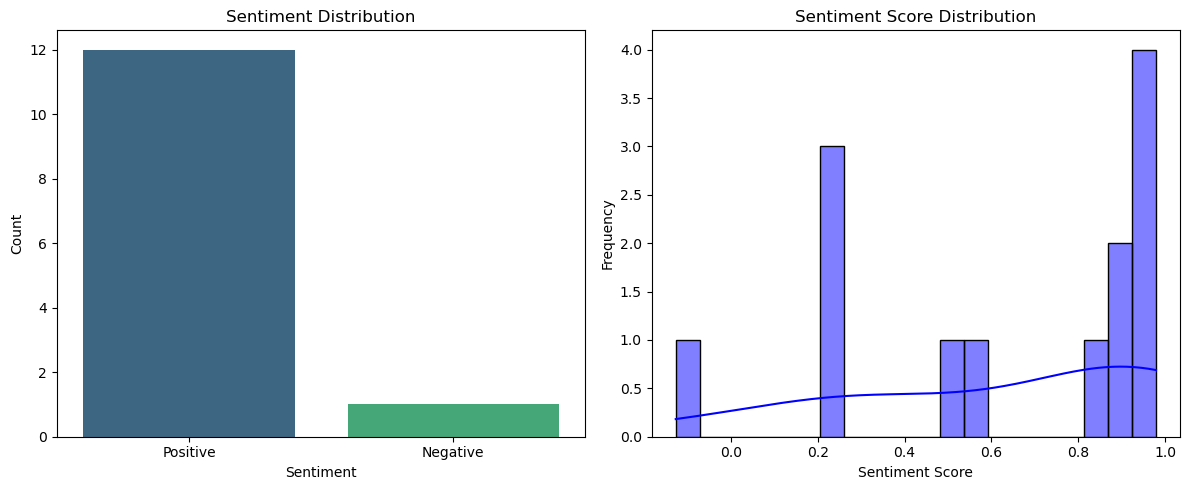

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
import time
import re
import matplotlib.pyplot as plt
import seaborn as sns
from deep_translator import GoogleTranslator

# Download VADER lexicon (only required once)
nltk.download('vader_lexicon')

# Initialize Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to clean review text
def clean_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    return text

# Function to translate reviews to English
def translate_review(review):
    try:
        translated_text = GoogleTranslator(source='auto', target='en').translate(review)
        return translated_text
    except:
        return review  # If translation fails, return original text

# Function to scrape Amazon reviews
def scrape_amazon_reviews(base_url, max_pages=2):
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64)'}
    reviews = []
    page_num = 1

    while page_num <= max_pages:
        print(f"🔄 Scraping Page {page_num}...")
        response = requests.get(base_url, headers=headers)

        if response.status_code != 200:
            print("❌ Failed to retrieve page. Check the URL or try again later.")
            break

        soup = BeautifulSoup(response.text, 'html.parser')
        review_blocks = soup.find_all('span', {'data-hook': 'review-body'})

        if not review_blocks:
            print("🚫 No more reviews found.")
            break

        for review in review_blocks:
            review_text = review.get_text(strip=True)
            reviews.append(review_text)

        # Find the next page link
        next_page = soup.find('li', class_='a-last')
        if next_page and next_page.find('a'):
            next_page_url = "https://www.amazon.in" + next_page.find('a')['href']
            base_url = next_page_url  # Update URL for next page
            time.sleep(2)  # Avoid getting blocked
        else:
            print("✅ No more pages available.")
            break

        page_num += 1

    return reviews

# Function to analyze sentiment
def analyze_sentiment(reviews):
    sentiments = []

    for review in reviews:
        translated_review = translate_review(review)  # Translate to English
        cleaned_review = clean_text(translated_review)
        sentiment_score = sia.polarity_scores(cleaned_review)['compound']
        
        # ✅ Improved sentiment classification
        if sentiment_score > 0.2:
            sentiment_label = 'Positive'
        elif sentiment_score < 0:  # Anything below 0 is now Negative
            sentiment_label = 'Negative'
        else:
            sentiment_label = 'Neutral'

        sentiments.append((review, translated_review, sentiment_score, sentiment_label))

    return sentiments

# Function to visualize sentiment distribution
def visualize_data(df):
    plt.figure(figsize=(12, 5))

    # 1️⃣ Bar Chart for Sentiment Count
    plt.subplot(1, 2, 1)
    sns.countplot(x=df['Review Sentiment'], palette='viridis')
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")

    # 2️⃣ Histogram for Sentiment Score
    plt.subplot(1, 2, 2)
    sns.histplot(df['Sentiment Score'], bins=20, kde=True, color="blue")
    plt.title("Sentiment Score Distribution")
    plt.xlabel("Sentiment Score")
    plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Amazon product reviews URL
amazon_url = "https://www.amazon.in/AmazonBasics-Height-Adjustable-5-Shelves-Heavy/dp/B018YLFJX4/ref=s9_acsd_al_ot_c2_x_0_t?_encoding=UTF8&pf_rd_t="

# Scrape reviews using BeautifulSoup
reviews = scrape_amazon_reviews(amazon_url, max_pages=2)

if reviews:
    analyzed_reviews = analyze_sentiment(reviews)
    df = pd.DataFrame(analyzed_reviews, columns=['Original Review', 'Translated Review', 'Sentiment Score', 'Review Sentiment'])

    # Save to CSV
    df.to_csv("amazon_reviews_sentiment.csv", index=False, encoding='utf-8')
    print(df)
    print("\n✅ Scraped", len(reviews), "reviews and saved to 'amazon_reviews_sentiment.csv'")

    # Visualize sentiment distribution
    visualize_data(df)

else:
    print("❌ No reviews found.")
